## CuLSH

In [1]:
#!pip install pycuda
#https://pypi.org/project/pycuda/
#https://documen.tician.de/pycuda/
#https://stackoverflow.com/questions/68256354/cuda-c-library-in-python-transfer-gpu-memory-data-from-one-functions-to-ower
#https://forums.developer.nvidia.com/t/fast-memcpy-micro-benchmarking-cuda-python-wrapper-multi-gpu-seg-fault/274712

In [10]:
# backup
#https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_Deep_Supervised_Hashing_CVPR_2016_paper.pdf
#https://github.com/thuml/HashNet/tree/master
#https://github.com/flyingpot/pytorch_deephash
#https://github.com/weixu000/DSH-pytorch/blob/master/utils.py
#https://github.com/swuxyj/DeepHash-pytorch?tab=readme-ov-file
#https://github.com/dansuh17/deep-supervised-hashing
#https://github.com/inducer/pycuda/blob/main/examples/demo_elementwise.py

In [11]:
#Hash on gpu
#https://docs.rapids.ai/api/libcudf/stable/group__nvtext__minhash


#https://on-demand.gputechconf.com/gtc/2015/presentation/S5796-Peter-Andreas-Entschev.pdf
#https://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html
#http://www.phash.org/


In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy

from pycuda.compiler import SourceModule
mod = SourceModule("""
__global__ void multiply_them(float *dest, float *a, float *b)
{
  const int i = threadIdx.x;
  dest[i] = a[i] * b[i];
}
""")

multiply_them = mod.get_function("multiply_them")

a = numpy.random.randn(20).astype(numpy.float32)
b = numpy.random.randn(20).astype(numpy.float32)


print(a)
print(b)
dest = numpy.zeros_like(a)
multiply_them(
        drv.Out(dest), drv.In(a), drv.In(b),
        block=(400,1,1), grid=(1,1))

print(dest-a*b)

[-0.8100255  -0.01414014  0.5225501  -0.12430553 -1.2071519  -0.02677498
 -2.1725597  -0.00758595  0.43171266 -0.98019135 -1.0585554  -0.16486582
  0.14446566 -1.8081325   0.25928038 -0.26264107 -0.1574377  -1.540724
  0.7348782  -0.46492755]
[ 0.894133   -1.5382648  -1.9045494   1.4757626   0.10467634 -1.2022027
  0.9861409   0.73430675  1.5527244  -0.825056    0.07589551 -0.40221387
  0.46693218  0.86396796  0.87781686 -0.87351185 -0.38448521  0.22333542
  0.19107658  0.12427776]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### 1. Load Cifar

In [8]:
import os
import _pickle as cPickle
import numpy as np

PATH = "../data/cifar-10-batches-py/"

In [9]:
def load_batch():
    file = 'data_batch_1'

    f = open(PATH+file, 'rb')
    dict = cPickle.load(f, encoding='latin1')
    images = dict['data']
    #images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

In [10]:
def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [11]:
images, labels = load_batch()

In [32]:
special_image = images[0]

In [35]:
special_image = np.reshape(special_image, (3, 32, 32)).T

In [36]:
special_image.shape

(32, 32, 3)

In [64]:
special_image

array([[[ 59,  62,  63],
        [ 16,  20,  20],
        [ 25,  24,  21],
        ...,
        [208, 170,  96],
        [180, 139,  96],
        [177, 144, 116]],

       [[ 43,  46,  45],
        [  0,   0,   0],
        [ 16,   7,   0],
        ...,
        [201, 153,  34],
        [173, 123,  42],
        [168, 129,  94]],

       [[ 50,  48,  43],
        [ 18,   8,   0],
        [ 49,  27,   8],
        ...,
        [198, 161,  26],
        [186, 144,  30],
        [179, 142,  87]],

       ...,

       [[158, 132, 108],
        [123,  88,  55],
        [118,  84,  50],
        ...,
        [160, 133,  70],
        [184, 148,  94],
        [216, 184, 140]],

       [[152, 125, 102],
        [119,  83,  50],
        [120,  84,  50],
        ...,
        [ 56,  31,   7],
        [ 97,  62,  34],
        [151, 118,  84]],

       [[148, 124, 103],
        [122,  87,  57],
        [109,  73,  42],
        ...,
        [ 53,  34,  20],
        [ 83,  53,  34],
        [123,  92,  72]]

### 2. Preprocesing 

In [165]:
def scale_image_down_and_gray(np_image, new_rows, new_columns):
    
    columns = np_image.shape[0]
    rows = np_image.shape[1]

    factor_columns = columns / new_columns
    factor_rows = rows / new_rows

    new_image = np.empty([new_columns, new_rows, 1], dtype=numpy.uint8)

    print(new_image.shape)
    
    for row in range(new_rows):
        for col in range(new_columns):
            new_row = int(row * factor_rows)
            new_col = int(col * factor_columns)

            pixel = 0.2989 * np_image[new_col][new_row][0] \
                  + 0.5870 * np_image[new_col][new_row][1] \
                  + 0.1140 * np_image[new_col][new_row][2]
            
            new_image[col][row][0] = pixel
    return new_image

def scale_image_up(np_image, new_width, new_height):
    pass

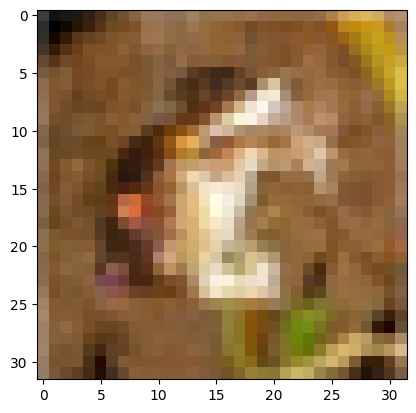

In [176]:
from matplotlib import pyplot as plt
plt.imshow(special_image, interpolation='nearest')
plt.show()

In [177]:
down_scaled_image = scale_image_down_and_gray(special_image, 20, 24)

(24, 20, 1)


In [178]:
down_scaled_image.shape

(24, 20, 1)

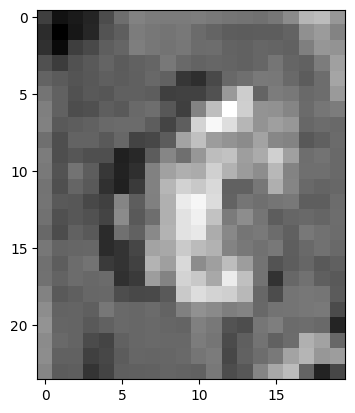

In [179]:
plt.imshow(down_scaled_image, cmap='gray')
plt.show()

In [180]:
down_scaled_image.shape

(24, 20, 1)

In [181]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

### own kernel to image

In [182]:
# article - https://medium.com/@sim30217/bilinear-interpolation-e41fc8b63fb4
# Nearest Neighbor - which can result in visible artifacts or jagged edges.
# Billinar 
# Gaussian - https://medium.com/@rohit-krishna/coding-gaussian-blur-operation-from-scratch-in-python-f5a9af0a0c0f
# SPline ??? or other common kernel 
#http://forum.doom9.org/archive/index.php/t-145210.html